In [1]:
pip install pymagnitude==0.1.34

/bin/bash: pip: command not found


In [2]:
pip install pymagnitude==0.1.143

/bin/bash: pip: command not found


In [3]:
pip install pymagnitude git+https://github.com/huggingface/pytorch-pretrained-BERT.git -q

/bin/bash: pip: command not found


In [4]:
pip install wordcloud

/bin/bash: pip: command not found


In [5]:
pip install gensim

/bin/bash: pip: command not found


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from gensim.models import Word2Vec
from nltk import word_tokenize, FreqDist
import PIL
from collections import Counter
import itertools
import gc
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
pip install bert-for-tf2

/bin/bash: pip: command not found


In [8]:
pip install pytorch-transformers

/bin/bash: pip: command not found


In [9]:
from pathlib import Path

import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
#from google_drive_downloader import GoogleDriveDownloader as gdd
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm, tqdm_notebook

In [10]:
pip install pytorch_pretrained_bert

/bin/bash: pip: command not found


In [11]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import random
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex as re
from pymagnitude import Magnitude
from pytorch_pretrained_bert import BertTokenizer, BertForSequenceClassification, BertAdam
from sklearn.metrics import classification_report
from tqdm import tqdm, tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.dataset import random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from IPython.core.display import display, HTML
#from google_drive_downloader import GoogleDriveDownloader as gdd

tqdm.pandas()

# If the machine you run this on has a GPU available with CUDA installed,
# use it. Using a GPU for learning often leads to huge speedups in training.
# See https://developer.nvidia.com/cuda-downloads for installing CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
DATA_PATH = '/content/gdrive/My Drive/FYP/report/Bert/datasets2with6000.csv'

In [15]:
used_cols = ['combined_text', 'target' ]

In [16]:
class FakeNewsNetDataset(Dataset):
    def __init__(self, data_path, max_len):
        df = pd.read_csv(DATA_PATH)
        df = df[used_cols]
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        df['tokenized_text'] = df.combined_text.apply(self.tokenizer.tokenize)
        
        # Shorten to max length (Bert has a limit of 512); subtract two tokens for [CLS] and [SEP]
        df.loc[:, 'tokenized_text'] = df.tokenized_text.str[:max_len - 2]
        
        # Add Bert-specific beginning and end tokens
        df.loc[:, 'tokenized_text'] = df.tokenized_text.apply(
            lambda tokens: ['[CLS]'] + tokens + ['[SEP]'],
        )
        
        df['indexed_tokens'] = df.tokenized_text.apply(
            self.tokenizer.convert_tokens_to_ids,
        )
        
        sequences = df.indexed_tokens.tolist()
        max_sequence_length = max(len(x) for x in sequences)
        
        self.inputs_lst, self.masks, self.segments = [], [], []
        for sequence in sequences:
            self.inputs_lst.append(sequence + (max_sequence_length - len(sequence)) * [0])
            self.masks.append(len(sequence) * [1] + (max_sequence_length - len(sequence)) * [0])
            self.segments.append(max_sequence_length * [0])
            
        self.targets = df.target.tolist()
        self.texts = df.combined_text.tolist()

    def __getitem__(self, i):
        return self.inputs_lst[i], self.masks[i], self.segments[i], self.targets[i], self.texts[i]
    
    def __len__(self):
        return len(self.inputs_lst)

In [17]:
# How many tokens long each sequence will be cut to
# Shorter sequences will get the padding token <PAD>
max_len = 200  #@param {type:"slider", min:16, max:512, step:2}

dataset = FakeNewsNetDataset(DATA_PATH, max_len)

In [18]:
# Splitting up the data

def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    """Split dataset into train, validation, and test."""
    test_length = int(len(corpus) * test_ratio)
    valid_length = int(len(corpus) * valid_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length],
    )

valid_ratio = 0.2  #@param {type:"slider", min:0.01, max:0.3, step:0.01}
test_ratio = 0.1 #@param {type:"slider", min:0.01, max:0.3, step:0.01}

# Train on only a subset of the data to reduce training time
n_samples = 7000 #@param {type:"integer"}

train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset,
    valid_ratio,
    test_ratio,
)
train_dataset = Subset(train_dataset, torch.randperm(len(train_dataset))[:n_samples])
len(train_dataset), len(valid_dataset), len(test_dataset)

(4435, 1267, 633)

In [19]:
#@title How many examples to load on the GPU at once

def collate(batch):
    inputs = torch.LongTensor([item[0] for item in batch])
    mask = torch.LongTensor([item[1] for item in batch])
    segment = torch.LongTensor([item[2] for item in batch])
    target = torch.LongTensor([item[3] for item in batch])
    text = [item[4] for item in batch]
    
    inputs, mask, segment, target = map(
        lambda x: x.to(device),
        (inputs, mask, segment, target),
    )

    return inputs, mask, segment, target, text

batch_size = 32  #@param {type:"integer"}

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate)

In [20]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)

learning_rate = 0.001  #@param {type:"number"}

param_optimizer = list(model.classifier.named_parameters()) 
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer]}]
optimizer = BertAdam(optimizer_grouped_parameters, lr=learning_rate)

t_total value of -1 results in schedule not being applied


In [21]:
def train_epoch(model, optimizer, train_loader):
    model.train()
    train_loss = total = 0
    for inputs, mask, segment, target, text in tqdm_notebook(train_loader,
                                                             desc='Training',
                                                             leave=False):
        optimizer.zero_grad()
        
        loss = model(inputs, segment, mask, target)

        train_loss += loss.item()
        total += 1
        
        loss.backward()
        optimizer.step()
        
    return train_loss / total


def validate_epoch(model, valid_loader):
    model.eval()
    with torch.no_grad():
        valid_loss = total = 0
        for inputs, mask, segment, target, text in tqdm_notebook(valid_loader,
                                                                 desc='Validating',
                                                                 leave=False):
            loss = model(inputs, segment, mask, target)

            valid_loss += loss.item()
            total += 1

        return valid_loss / total

In [22]:
#@title Limit the number of training epochs (training is slow)

max_epochs = 10 #@param {type:"slider", min:1, max:10}

n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(model, optimizer, train_loader)
    valid_loss = validate_epoch(model, valid_loader)
    
    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.3f}\tvalid_loss: {valid_loss:.3f}\n',
    )
    
    # Early stopping if the current valid_loss is
    # greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss > loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    n_epochs += 1
    
    if n_epochs >= max_epochs:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


epoch #  1	train_loss: 0.353	valid_loss: 0.332



epoch #  2	train_loss: 0.237	valid_loss: 0.195



epoch #  3	train_loss: 0.206	valid_loss: 0.184



epoch #  4	train_loss: 0.201	valid_loss: 0.160



epoch #  5	train_loss: 0.203	valid_loss: 0.166



epoch #  6	train_loss: 0.195	valid_loss: 0.155



epoch #  7	train_loss: 0.191	valid_loss: 0.180

Stopping early


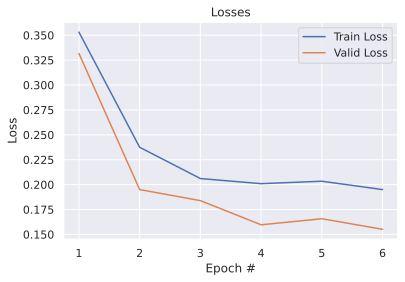

In [30]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [31]:
model.eval()
y_true, y_pred = [], []

In [32]:
with torch.no_grad():
    for inputs, mask, segment, target, text in test_loader:
        loss = model(inputs, segment, mask, target)
        logits = model(inputs, segment, mask)
        
        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)
        target = target.cpu().numpy()
        
        y_true.extend(predictions)
        y_pred.extend(target)

In [33]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       336
           1       0.92      0.98      0.95       297

    accuracy                           0.95       633
   macro avg       0.95      0.95      0.95       633
weighted avg       0.95      0.95      0.95       633



In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[309,  27],
       [  6, 291]])

In [35]:
from sklearn import metrics
print(metrics.accuracy_score(y_true, y_pred))

0.9478672985781991


In [ ]:
flatten = lambda x: [sublst for lst in x for sublst in lst]
inputs_lst, mask_lst, segment_lst, target_lst, text_lst = zip(*test_loader)
inputs_lst, mask_lst, segment_lst, target_lst, text_lst = map(flatten, [inputs_lst, mask_lst, segment_lst, target_lst, text_lst])
test_examples = list(zip(inputs_lst, mask_lst, segment_lst, target_lst, text_lst))

def print_random_prediction(n=10):
    to_emoji = lambda x: '❌' if x else '✅'
    model.eval()
    rows = []
    for _ in range(n):
        with torch.no_grad():
            inputs, target, segment, target, text = random.choice(test_examples)

            logits = model(inputs.unsqueeze(0))
            logits = logits.detach().cpu().numpy()
            prediction = np.argmax(logits, axis=1)[0]

            predicted = to_emoji(prediction)
            actual = to_emoji(target)
            
            row = f"""
            <tr>
            <td>{text}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            <td>{actual}&nbsp;</td>
            </tr>
            """
            rows.append(row)
            
    rows_joined = '\n'.join(rows)
    table = f"""
<table>
<tbody>
<tr>
<td><b>News</b>&nbsp;</td>
<td><b>Predicted</b>&nbsp;</td>
<td><b>Actual</b>&nbsp;</td>
</tr>
{rows_joined}
</tbody>
</table>
"""
    display(HTML(table))

In [ ]:
print_random_prediction(n=3)